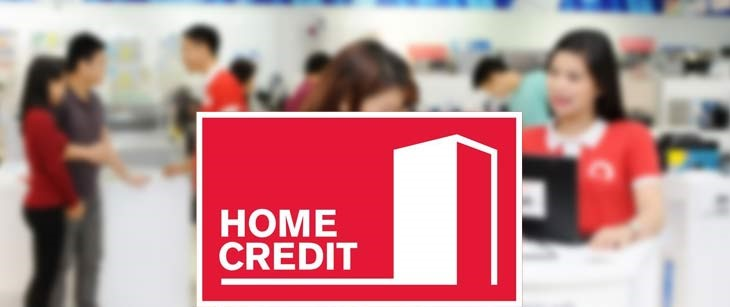

<img src="https://storage.googleapis.com/kaggle-competitions/kaggle/9120/logos/thumb76_76.png?t=2018-04-02-23-45-04" align="left" width = "100px"/>

<h1> Home Credit Default Risk</h1>

## Data Description
Many people struggle to get loans due to insufficient or non-existent credit histories. And, unfortunately, this population is often taken advantage of by untrustworthy lenders.

Home Credit strives to broaden financial inclusion for the unbanked population by providing a positive and safe borrowing experience. In order to make sure this underserved population has a positive loan experience, Home Credit makes use of a variety of alternative data--including telco and transactional information--to predict their clients' repayment abilities.

While Home Credit is currently using various statistical and machine learning methods to make these predictions, they're challenging Kagglers to help them unlock the full potential of their data. Doing so will ensure that clients capable of repayment are not rejected and that loans are given with a principal, maturity, and repayment calendar that will empower their clients to be successful.

## Datasets

<center> <div style="width:70%"><img src="https://storage.googleapis.com/kaggle-media/competitions/home-credit/home_credit.png"></img></div></center>

In [ ]:
######################################
# Kütüphanelerin import edilmesi
#####################################

import numpy as np
import pandas as pd
import gc
import time
from contextlib import contextmanager
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold, StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import re


@contextmanager
def timer(title):
    t0 = time.time()
    yield
    print("{} - done in {:.0f}s".format(title, time.time() - t0))
    
    
#######################
# Fonksiyonlar
#######################

# veri setine genel bakış
def check_df(dataframe):
    print("##################### Shape #####################")
    print(dataframe.shape)
    print("##################### Types #####################")
    print(dataframe.dtypes)
    
# Değişkenlerin türlerinin belirlenmesi
def grab_col_names(dataframe, cat_th=10, car_th=20):
    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    #print(f"Observations: {dataframe.shape[0]}")
    #print(f"Variables: {dataframe.shape[1]}")
    #print(f'cat_cols: {len(cat_cols)}')
    #print(f'num_cols: {len(num_cols)}')
    #print(f'cat_but_car: {len(cat_but_car)}')
    #print(f'num_but_cat: {len(num_but_cat)}')
    return cat_cols, num_cols, cat_but_car

# Eksik gözlemler
def missing_values_table(dataframe, na_name=False):
    na_columns = [col for col in dataframe.columns if dataframe[col].isnull().sum() > 0]
    n_miss = dataframe[na_columns].isnull().sum().sort_values(ascending=False)
    ratio = (dataframe[na_columns].isnull().sum() / dataframe.shape[0] * 100).sort_values(ascending=False)
    missing_df = pd.concat([n_miss, np.round(ratio, 2)], axis=1, keys=['n_miss', 'ratio'])
    print(missing_df, end="\n")
    if na_name:
        return na_columns
    
# Kategorik değişkenlerin incelenmesi
def cat_summary(dataframe, col_name, plot=False):
    print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                        "Ratio": 100 * dataframe[col_name].value_counts() / len(dataframe)}))
    print("##########################################")
    if plot:
        plt.figure(figsize=(10,5))
        sns.countplot(x=dataframe[col_name], data=dataframe)
        plt.show()
        
# Nümerik değişkenlerin incelenmesi
def num_summary(dataframe, numerical_col, plot=False):
    quantiles = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]
    print(dataframe[numerical_col].describe(quantiles).T)
    if plot:
        dataframe[numerical_col].hist(bins=20)
        plt.xlabel(numerical_col)
        plt.title(numerical_col)
        plt.show()
        
        
# Korelasyonlar
def high_correlation(data, remove=['SK_ID_CURR', 'SK_ID_BUREAU'], corr_coef="pearson", corr_value = 0.7):
    if len(remove) > 0:
        cols = [x for x in data.columns if (x not in remove)]
        c = data[cols].corr(method=corr_coef)
    else:
        c = data.corr(method=corr_coef)

    for i in c.columns:
        cr = c.loc[i].loc[(c.loc[i] >= corr_value) | (c.loc[i] <= -corr_value)].drop(i)
        if len(cr) > 0:
            print(i)
            print("-------------------------------")
            print(cr.sort_values(ascending=False))
            print("\n")

# Rare Encoding
def rare_encoder(dataframe, rare_perc, cat_cols):
   
    rare_columns = [col for col in cat_cols if
                    (dataframe[col].value_counts() / len(dataframe) < rare_perc).sum() > 1]

    for col in rare_columns:
        tmp = dataframe[col].value_counts() / len(dataframe)
        rare_labels = tmp[tmp < rare_perc].index
        dataframe[col] = np.where(dataframe[col].isin(rare_labels), 'Rare', dataframe[col])

    return dataframe

# One-hot Encoding 
def one_hot_encoder(df, nan_as_category = True):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns= categorical_columns, dummy_na= nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns


#########################
# Application_train_test
#########################

def application_train_test(num_rows = None, nan_as_category = False):
    # Veri setinin okutulması
    df = pd.read_csv('../input/home-credit-default-risk/application_train.csv', nrows= num_rows)
    test_df = pd.read_csv('../input/home-credit-default-risk/application_test.csv', nrows= num_rows)
    print("Train samples: {}, test samples: {}".format(len(df), len(test_df)))
    df = df.append(test_df).reset_index()
    
    # Cinsiyeti belirtilmeyen 4 kişi var bunları çıkarıyoruz.
    df = df[df['CODE_GENDER'] != 'XNA']
    # Medeni durumu unknown olan 1 kişi var bunu dropladık.
    df = df[df['NAME_FAMILY_STATUS'] != "Unknown" ]
    # NaN values for DAYS_EMPLOYED: 365243 -> nan
    df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace=True)
    
    ########
    # RARE
    ########
    # NAME_INCOME_TYPE değişkeninin 4 sınıfının frekansı diğerlerine göre düşük olduğunu gözlemledik.
    # Bu nedenle bu 4 sınıfı kendilerine en yakın olabilecek sınıfın için dahil ettik.
    # Yani rare sınıfını diğerlerine eklemiş olduk.
    df.loc[df['NAME_INCOME_TYPE'] == 'Businessman', 'NAME_INCOME_TYPE'] = 'Commercial associate'
    df.loc[df['NAME_INCOME_TYPE'] == 'Maternity leave', 'NAME_INCOME_TYPE'] = 'Pensioner'
    df.loc[df['NAME_INCOME_TYPE'] == 'Student', 'NAME_INCOME_TYPE'] = 'State servant'
    df.loc[df['NAME_INCOME_TYPE'] == 'Unemployed', 'NAME_INCOME_TYPE'] = 'Pensioner'
    
    # ORGANIZATION_TYPE
    df["ORGANIZATION_TYPE"] = np.where(df["ORGANIZATION_TYPE"].str.contains("Business Entity"), 
                                       "Business_Entity", df["ORGANIZATION_TYPE"])
    df["ORGANIZATION_TYPE"] = np.where(df["ORGANIZATION_TYPE"].str.contains("Industry"), 
                                       "Industry", df["ORGANIZATION_TYPE"])
    df["ORGANIZATION_TYPE"] = np.where(df["ORGANIZATION_TYPE"].str.contains("Trade"),
                                       "Trade", df["ORGANIZATION_TYPE"])
    df["ORGANIZATION_TYPE"] = np.where(df["ORGANIZATION_TYPE"].str.contains("Transport"),
                                       "Transport", df["ORGANIZATION_TYPE"])
    df["ORGANIZATION_TYPE"] = np.where(df["ORGANIZATION_TYPE"].isin(["School", "Kindergarten", "University"]),
                                       "Education", df["ORGANIZATION_TYPE"])
    df["ORGANIZATION_TYPE"] = np.where(df["ORGANIZATION_TYPE"].isin(["Emergency","Police", "Medicine","Goverment", "Postal", "Military", "Security Ministries", "Legal Services"]), "Official", df["ORGANIZATION_TYPE"])
    df["ORGANIZATION_TYPE"] = np.where(df["ORGANIZATION_TYPE"].isin(["Bank", "Insurance"]),
                                       "Finance", df["ORGANIZATION_TYPE"])
    df["ORGANIZATION_TYPE"] = np.where(df["ORGANIZATION_TYPE"].str.contains("Goverment"), 
                                       "Government", df["ORGANIZATION_TYPE"])
    df["ORGANIZATION_TYPE"] = np.where(df["ORGANIZATION_TYPE"].isin(["Realtor", "Housing"]), "Realty", df["ORGANIZATION_TYPE"])
    df["ORGANIZATION_TYPE"] = np.where(df["ORGANIZATION_TYPE"].isin(["Hotel", "Restaurant","Services"]), "TourismFoodSector", df["ORGANIZATION_TYPE"])
    df["ORGANIZATION_TYPE"] = np.where(df["ORGANIZATION_TYPE"].isin(["Cleaning","Electricity", "Telecom", "Mobile", "Advertising", "Religion", "Culture"]), "Other", df["ORGANIZATION_TYPE"])
    
    
    # OCCUPATION_TYPE
    df["OCCUPATION_TYPE"] = np.where(df["OCCUPATION_TYPE"].isin(["Low-skill Laborers", "Cooking staff", "Security staff", "Private service staff", "Cleaning staff", "Waiters/barmen staff"]), "Low_skill_staff", df["OCCUPATION_TYPE"])
    df["OCCUPATION_TYPE"] = np.where(df["OCCUPATION_TYPE"].isin(["IT staff", "High skill tech staff"]), "High_skill_staff", df["OCCUPATION_TYPE"])
    df["OCCUPATION_TYPE"] = np.where(df["OCCUPATION_TYPE"].isin(["Secretaries", "HR staff","Realty agents"]), "Others", df["OCCUPATION_TYPE"])

    # NAME_TYPE_SUITE
    rare_list = ["NAME_TYPE_SUITE"]
    rare_encoder(df, 0.01, rare_list)
    
    # NAME_EDUCATION_TYPE
    # Akademik derecenin frekansı az olduğu için bununla yüksek eğitimi aynı sınıfa aldık.
    df["NAME_EDUCATION_TYPE"] = np.where(df["NAME_EDUCATION_TYPE"] == "Academic degree",
                                         "Higher education", df["NAME_EDUCATION_TYPE"])
    
    df["NAME_EDUCATION_TYPE"] = np.where(df["NAME_EDUCATION_TYPE"].str.contains("Secondary / secondary special"),
                                         "Secondary_secondary_special", df["ORGANIZATION_TYPE"])
    
    # NAME_FAMILY_STATUS
    df["NAME_FAMILY_STATUS"] = np.where(df["NAME_FAMILY_STATUS"].str.contains("Single / not married"),
                                        "Single_not_married", df["NAME_FAMILY_STATUS"])
    
    
    # NAME_HOUSING_TYPE
    df["NAME_HOUSING_TYPE"] = np.where(df["NAME_HOUSING_TYPE"].str.contains("House / apartment"),
                                       "House_apartment", df["NAME_HOUSING_TYPE"])
    
    # NAME_TYPE_SUITE
    df["NAME_TYPE_SUITE"] = np.where(df["NAME_TYPE_SUITE"].str.contains("Spouse, partner"),
                                       "Spouse_partner", df["NAME_TYPE_SUITE"])
    
    
    # NAME_CONTRACT_TYPE
    # Kategorik olan ama cinsiyet gibi 0 ve 1 olarak kodlanacak değişkenlere binary encode yaptık.
    for bin_feature in ["NAME_CONTRACT_TYPE", 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
        df[bin_feature], uniques = pd.factorize(df[bin_feature])
    
    # WEEKDAY_APPR_PROCESS_START
    # Gün isimlerini 1,2,3....,7 olarak değiştireceğiz.
    # Daha sonra günler döngüsel yapıda oldukları için bunlara cycle encode uygulayacağız.
    # Asıl değişkenleri silmedik feature importance da bak!
    weekday_dict = {'MONDAY': 1, 'TUESDAY': 2, 'WEDNESDAY': 3, 'THURSDAY': 4, 'FRIDAY': 5, 'SATURDAY': 6, 'SUNDAY': 7}
    df.replace({'WEEKDAY_APPR_PROCESS_START': weekday_dict}, inplace=True)
    # Cycle encode
    df['NEW_WEEKDAY_APPR_PROCESS_START' + "_SIN"] = np.sin(2 * np.pi * df["WEEKDAY_APPR_PROCESS_START"]/7)
    df["NEW_WEEKDAY_APPR_PROCESS_START" + "_COS"] = np.cos(2 * np.pi * df["WEEKDAY_APPR_PROCESS_START"]/7)
    
    # HOUR_APPR_PROCESS_START
    # değişken müşterinin hangi saatte başvurduğu bilgisini veriyordu.
    # Saat bilgisi de yine döngüsel olduğu için buna da cycle encode yapıyoruz.
    df['NEW_HOUR_APPR_PROCESS_START' + "_SIN"] = np.sin(2 * np.pi * df["HOUR_APPR_PROCESS_START"]/23)
    df["NEW_HOUR_APPR_PROCESS_START" + "_COS"] = np.cos(2 * np.pi * df["HOUR_APPR_PROCESS_START"]/23)
  
    ###########
    # DROP
    ###########
    # FLAG_MOBIL ve FLAG_CONT_MOBILE değişkenlerinde iki alt sınıfı var ve birinin frekansı çok az.
    # Yani bilgi taşımayan değişken bu nedenle drop ediyoruz.
    drop_cols = ["FONDKAPREMONT_MODE", "WALLSMATERIAL_MODE", "HOUSETYPE_MODE",
                 "EMERGENCYSTATE_MODE","FLAG_MOBIL", "FLAG_EMP_PHONE","FLAG_WORK_PHONE", "FLAG_CONT_MOBILE", "FLAG_PHONE", "FLAG_EMAIL"]
    df.drop(drop_cols, axis = 1, inplace = True)
    
    # OBS_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE
    df.drop(['OBS_30_CNT_SOCIAL_CIRCLE','OBS_60_CNT_SOCIAL_CIRCLE'], axis = 1, inplace = True)
    
    # REGION
    # Bu değişkenler bölge ve şehir bazında ayrı ayrı puan veriyordu
    # Biz bunları toplayarak tek bir değişken elde ettik ve diğerlerini dropladık.
    cols = ["REG_REGION_NOT_LIVE_REGION","REG_REGION_NOT_WORK_REGION", "LIVE_REGION_NOT_WORK_REGION", 
            "REG_CITY_NOT_LIVE_CITY","REG_CITY_NOT_WORK_CITY","LIVE_CITY_NOT_WORK_CITY"]
    df["NEW_REGION"] = df[cols].sum(axis = 1)
    df.drop(cols, axis = 1, inplace = True)
    
    # Flag_DOCUMENT
    # Bu değişkenler her dökümanın ayrı ayrı verilip verilmediği bilgisini veriyordu.
    # Biz bunları toplayarak tek bir değişken elde ettik,yani totalde verilen belge sayısını hesapladık
    # ve diğerlerini dropladık.
    docs = [col for col in df.columns if 'FLAG_DOC' in col]
    df['NEW_DOCUMENT'] = df[docs].sum(axis=1)
    df.drop(docs, axis = 1, inplace = True)
    
    ##########################
    # FEATURE ENGINEERING
    ##########################
    # 1. Müşteri başvurudan ne kadar önce işe başladı(gün) / müşterinin yaşı(gün)
    df['NEW_DAYS_EMPLOYED_RATIO'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']

    # 2. Müşterinin toplam geliri / kredi tutarı
    df['NEW_INCOME_CREDIT_RATIO'] = df['AMT_INCOME_TOTAL'] / df['AMT_CREDIT']

    # 3. Müşterinin toplam geliri / aile üyesi süresi
    # Ailede kişi başına ne kadar gelir var bunu ortaya çıkarıyor.
    df['NEW_INCOME_PER_RATIO'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']

    # 4. Kredinin yıllık ödemesi / Müşterinin geliri
    # Eğer bu değer 0-1 arasındaysa iyi yani geliri kredi ödemesinden fazla
    # Eğer bu değer 1 ise kötü yani geliri kredi ödemesinden daha az.
    df['NEW_ANNUITY_INCOME_RATIO'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']

    # 5. Kredinin yıllık ödemesi / kredi tutarı
    df['NEW_PAYMENT_RATIO'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']
    
    # 6. EXT_SOURCE değişkenleri dışarıdan alınan puanlardı.Ortalamaları ile yeni bir değişken oluşturduk.
    df["NEW_EXTSOURCE_MEAN"] = df[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].mean(axis=1)

    # 7. Bu değişkenleri çarparak ağırlıklı yeni bir değişken oluşturduk.
    df['NEW_EXTSOURCES_WPOINT'] = df['EXT_SOURCE_1'] * df['EXT_SOURCE_2'] * df['EXT_SOURCE_3']
    
    # 8. Kredi ile satın alınacak malların fiyatı / toplam kredi tutarı
    # Bu oran 0-1 arasında ise müşterinin alacağı mal fiyatından daha fazla kredi çekmesi demek.
    # Bu oranın 1 olması demek müşterinin ihtiyacı kadar kredi çektiği anlamına gelir.
    # Bu oran 1 den büykse müşteri ihtiyacından daha az kredi çekmiş demektir.
    df["NEW_GOODS_CREDIT_RATIO"] = df["AMT_GOODS_PRICE"] / df["AMT_CREDIT"]
    
    # 9.Yukarıdaki değişkenle bağlantılı olarak:
    # Bu fark 0 dan büyükse ihtiyacından az kredi çekmiş
    # 0 olursa ihtiyacı kadar çekmiş
    # 0 dan küçükse ihtiyacından fazla çekmiş
    df["NEW_GOODS_CREDIT_DIFF"] = df["AMT_GOODS_PRICE"] - df["AMT_CREDIT"]
    
    # 10. (Kredi ile satın alınacak malların fiyatı / toplam kredi tutarı) / toplam gelir
    df["NEW_GOODS_CREDIT_DIFF_RATIO"] = (df["AMT_GOODS_PRICE"] - df["AMT_CREDIT"]) / df["AMT_INCOME_TOTAL"]
    
    # 11. Toplam gelir / müşterinin yaşı(gün cinsinden)
    df['NEW_INCOME_BIRTH_RATIO'] = df['AMT_INCOME_TOTAL'] / df['DAYS_BIRTH']
    
    # 12. Kişinin DAYS_BIRTH değişkeni gün cinsindn yaşını veriyordu.
    # Ama değerler - (çünkü şu kadar gün önce doğmuş bilgisini veriyor.)
    # Bu yüzden müşterinin yaşını bulmak için - ile çarpıp 360 a böleceğiz.
    df["NEW_DAYS_BIRTH"] = round(df["DAYS_BIRTH"]* -1 / 365)
    
    # 13. Yaşlara göre müşterileri segmentlere ayırma
    df.loc[df["NEW_DAYS_BIRTH"] <= 34 ,"NEW_SEGMENT_AGE"] = "Young"
    df.loc[(df["NEW_DAYS_BIRTH"] > 34)&(df["NEW_DAYS_BIRTH"] <= 54) ,"NEW_SEGMENT_AGE"] = "Middle_Age"
    df.loc[(df["NEW_DAYS_BIRTH"] > 54),"NEW_SEGMENT_AGE"] = "Old"
    
    # 14. Gelire göre müşterileri segmentlere ayırma
    df.loc[df["AMT_INCOME_TOTAL"] <= 112500 ,"NEW_SEGMENT_INCOME"] = "Low_Income"
    df.loc[(df["AMT_INCOME_TOTAL"] > 112500)&(df["AMT_INCOME_TOTAL"] <= 225000) ,"NEW_SEGMENT_INCOME"] = "Middle_Income"
    df.loc[(df["AMT_INCOME_TOTAL"] > 225000),"NEW_SEGMENT_INCOME"] = "High_Income"
    
    # 15. Kişi başvuru yaparken kimle birlikteydi?
    df.loc[df['NAME_TYPE_SUITE'] == 'Unaccompanied', 'NEW_TYPE_SUITE_CAT'] = 0
    df.loc[df['NAME_TYPE_SUITE'] != 'Unaccompanied', 'NEW_TYPE_SUITE_CAT'] = 1
    df.loc[df['NAME_TYPE_SUITE'].isnull(), 'NEW_TYPE_SUITE_CAT'] = np.nan
    
    # 16. Elimizde müşterinin çevresinde 30 ve 60 gün temerrüde düşmüş kişi sayısı bilgisini veren iki
    # değişken vardı. Biz 30 ve 60 günü birleştirerek;
    # müşterinin çevresinde temerrüde düşen varsa 1 etiketlesin
    # temerrüde düşen yoksa 0 etiketlesin dedik.
    df.loc[(df['DEF_30_CNT_SOCIAL_CIRCLE'] > 0) & (df['DEF_60_CNT_SOCIAL_CIRCLE'] > 0),
           'NEW_DEF_30_60_SOCIAL_CIRCLE'] = 1
    df.loc[(df['DEF_30_CNT_SOCIAL_CIRCLE'] > 0) & (df['DEF_60_CNT_SOCIAL_CIRCLE'] == 0),
           'NEW_DEF_30_60_SOCIAL_CIRCLE'] = 1
    df.loc[(df['DEF_30_CNT_SOCIAL_CIRCLE'] == 0) & (df['DEF_60_CNT_SOCIAL_CIRCLE'] > 0),
           'NEW_DEF_30_60_SOCIAL_CIRCLE'] = 1
    df.loc[(df['DEF_30_CNT_SOCIAL_CIRCLE'] == 0) & (df['DEF_60_CNT_SOCIAL_CIRCLE'] == 0),
           'NEW_DEF_30_60_SOCIAL_CIRCLE'] = 0
    
    ########################
    # One-Hot Encoding
    ########################
    df, cat_cols = one_hot_encoder(df, nan_as_category=False)
    
    # Dropping feature named index
    df.drop('index', axis=1, inplace=True)
    
    del test_df
    gc.collect()
    #print(df.columns.tolist())
    return df


###############################
# Bureau and Bureau Balance
##############################

def bureau_and_balance(num_rows = None, nan_as_category = True):
    df = pd.read_csv("../input/home-credit-default-risk/bureau_balance.csv", nrows = num_rows)
    bureau = pd.read_csv('../input/home-credit-default-risk/bureau.csv')
    #cat_cols, num_cols, cat_but_car = grab_col_names(df)
    df,df_cat=one_hot_encoder(df)
    
    # Bureau balance: Perform aggregations and merge with bureau.csv
    agg_list = {'MONTHS_BALANCE': ['min', 'max', 'size'] }
    for col in df_cat:
        agg_list[col] = ['mean','sum']

    bb_agg = df.groupby("SK_ID_BUREAU").agg(agg_list)
    # Degisken isimlerinin yeniden adlandirilmasi 
    bb_agg.columns = pd.Index([col[0] + "_" + col[1].upper() for col in bb_agg.columns.tolist()])
    # New feature
    bb_agg['NEW_STATUS_SCORE'] = bb_agg['STATUS_1_SUM'] + bb_agg['STATUS_2_SUM']^2 + bb_agg['STATUS_3_SUM']^3 + bb_agg['STATUS_4_SUM']^4 + bb_agg['STATUS_5_SUM']^5
    
    bureau_and_bb = bureau.join(bb_agg, how='left', on='SK_ID_BUREAU')
    bureau.drop(['SK_ID_BUREAU'], axis=1, inplace= True)
    del df, bb_agg
    gc.collect()

    cat_cols, num_cols, cat_but_car = grab_col_names(bureau_and_bb)
    rare_encoder(bureau_and_bb,0.2,cat_cols)
    
    #CREDIT_ACTIVE degiskeninin sinif sayisini 2'ye düşürdük (Closed-Active)
    bureau_and_bb['CREDIT_ACTIVE'] = bureau_and_bb['CREDIT_ACTIVE'].replace("Rare", 'Active')
    #CREDIT_CURRENCY değişkenin 1 sınıfı, veri setinin %99'unu kapladığı için yani dengesiz veri olduğu için anlamsız bilgi taşır.Bu yüzden çıkaracağız.
    bureau_and_bb.drop("CREDIT_CURRENCY", inplace = True, axis = 1)
    
    #######################
    # FEATURE ENGINEERING
    #######################
    # 1. Active ve Closed Krediler için kredi erken kapanmışmı? 
    # Eğer kredi durumu aktifse ve DAYS_CREDIT_ENDDATE değişkeni 0 dan küçükse(yani - olması
    # o kadar gün önce sona erdiği anlamına gelir.) bu kişi kredisini erken kapatmıştır.
    # Closed da da kredisi kapanmış ama erken ödemesi erken bitmiş olanlar var.
    bureau_and_bb.loc[(bureau_and_bb['CREDIT_ACTIVE'] == 'Active') & (bureau_and_bb['DAYS_CREDIT_ENDDATE'] < 0), 'NEW_EARLY_ACTİVE'] = 1
    bureau_and_bb.loc[(bureau_and_bb['CREDIT_ACTIVE'] == 'Closed') & (abs(bureau_and_bb['DAYS_CREDIT_ENDDATE']) < abs(bureau_and_bb['DAYS_ENDDATE_FACT']) ), 'NEW_EARLY_CLOSED'] = 1
    
    # 2. Uzatılmış Kredilerin 1 ile değiştirilmesi
    bureau_and_bb["NEW_CNT_CREDIT_PROLONG_CAT"] = bureau_and_bb.loc[:,'CNT_CREDIT_PROLONG']
    prolong = [1,2,3,4,5,6,7,8,9]
    bureau_and_bb["NEW_CNT_CREDIT_PROLONG_CAT"] = bureau_and_bb['NEW_CNT_CREDIT_PROLONG_CAT'].replace(prolong, 1)
    
    # 3. Kişi Kaç farklı kredi tipi almış
    temp_bu = bureau_and_bb[['SK_ID_CURR', 'CREDIT_TYPE']].groupby(by=['SK_ID_CURR'])['CREDIT_TYPE'].nunique().reset_index().rename(index=str, columns={'CREDIT_TYPE': 'NEW_BUREAU_LOAN_TYPES'})
    bureau_and_bb = bureau_and_bb.merge(temp_bu, on=['SK_ID_CURR'], how='left')
    
    # 4. Borç Oranı
    # Kredi Bürosuna olan mevcut borç / kredi bürosu için mevcut kredi 
    # 1 le toplamamızın sebebi tanımsızlık olmasın diye
    bureau_and_bb['NEW_DEPT_RATIO'] = bureau_and_bb['AMT_CREDIT_SUM_DEBT'] / (bureau_and_bb['AMT_CREDIT_SUM']+1)

    # 5.Kredi güncellenmesi yenimi ?
    # 90 günü baz aldık. Çünkü bankalarda 3 ay gecikmeden sonra işlem başlatılıyor.
    bureau_and_bb['NEWS_DAYS_CREDIT_UPDATE'] = bureau_and_bb['DAYS_CREDIT_UPDATE'].apply(lambda x : 'old' if x < -90 else 'new')
    #cat_cols, num_cols, cat_but_car = grab_col_names(bureau_and_bb)
    
    ###########################
    # One-Hot Encoding
    ###########################
    bureau_and_bb, bureau_and_bb_cat = one_hot_encoder(bureau_and_bb)
    
    # Bureau and bureau_balance numeric features
    num_aggregations = {'DAYS_CREDIT': ['min', 'max', 'mean', 'var'],
                        'DAYS_CREDIT_ENDDATE': ['min', 'max', 'mean'],
                        'DAYS_CREDIT_UPDATE': ['mean'],
                        'CREDIT_DAY_OVERDUE': ['max', 'mean'],
                        'DAYS_ENDDATE_FACT':['min', 'max', 'mean'],
                        'NEW_STATUS_SCORE':['min','mean','max'],
                        'AMT_CREDIT_MAX_OVERDUE': ['mean'],
                        'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
                        'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
                        'AMT_CREDIT_SUM_OVERDUE': ['mean'],
                        'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum'],
                        'AMT_ANNUITY': ['max', 'mean'],
                        'CNT_CREDIT_PROLONG': ['sum'],
                        'MONTHS_BALANCE_MIN': ['min'],
                        'MONTHS_BALANCE_MAX': ['max'],
                        'MONTHS_BALANCE_SIZE': ['mean', 'sum'],
                        'NEW_DEPT_RATIO': ['min','max','mean'] }

    # Bureau and bureau_balance categorical features
    cat_aggregations = {}
    for cat in bureau_and_bb_cat: cat_aggregations[cat] = ['mean']
    for cat in df_cat: cat_aggregations[cat + "_MEAN"] = ['mean']
    
    bureau_agg = bureau_and_bb.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    bureau_agg.columns = pd.Index(['BURO_' + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()])
    
    # Bureau: Active credits - using only numerical aggregations
    active = bureau_and_bb[bureau_and_bb['CREDIT_ACTIVE_Active'] == 1]
    active_agg = active.groupby('SK_ID_CURR').agg(num_aggregations)
    active_agg.columns = pd.Index(['ACTIVE_' + e[0] + "_" + e[1].upper() for e in active_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(active_agg, how='left', on='SK_ID_CURR')
    del active, active_agg
    
    # Bureau: Closed credits - using only numerical aggregations
    closed = bureau_and_bb[bureau_and_bb['CREDIT_ACTIVE_Closed'] == 1]
    closed_agg = closed.groupby('SK_ID_CURR').agg(num_aggregations)
    closed_agg.columns = pd.Index(['CLOSED_' + e[0] + "_" + e[1].upper() for e in closed_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(closed_agg, how='left', on='SK_ID_CURR')
    del closed, closed_agg, bureau
    gc.collect()
    #print(bureau_agg.columns.tolist())
    return bureau_agg

###########################
# Previous_application
###########################

def previous_applications(num_rows = None, nan_as_category = True):
    df = pd.read_csv("../input/home-credit-default-risk/previous_application.csv", nrows = num_rows)
    cat_cols, num_cols, cat_but_car = grab_col_names(df)
    
    
    # Nümerik değişkenleri incelerken bazı değişkenlerin max değerinin gerçek dışı 
    # yani çok büyük olduğunu gördük.365 e böldük 1000 yıl gibi bir değer geldi.
    # Bu sebeple bu kolondaki böyle büyük değerlere Nan değeri atayacağım
    df['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace= True)
    df['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace= True)
    df['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace= True)
    df['DAYS_LAST_DUE'].replace(365243, np.nan, inplace= True)
    df['DAYS_TERMINATION'].replace(365243, np.nan, inplace= True)
    
    # Bazı kategorik değişkenlerin alt sınıfları XNA, XAP olarak yazılmış aslında bunlar nan değer.
    # Bu yüzden bunlara nan atıyoruz.
    na = ['XNA', 'XAP']
    for col in cat_cols:
        for n in na:
            df.loc[df[col] == n, col] = np.nan

    #########
    # RARE
    ########
    rare_encoder(df, 0.01,cat_cols)
    
    # NAME_GOODS_CATEGORY
    # Bu değişkenin bazı alt sınıflarını others da topladık.
    a = ['Auto Accessories', 'Jewelry', 'Homewares', 'Medical Supplies', 'Vehicles', 'Sport and Leisure', 
         'Gardening', 'Other', 'Office Appliances', 'Tourism', 'Medicine', 'Direct Sales', 'Fitness', 'Additional Service', 
         'Education', 'Weapon', 'Insurance', 'House Construction', 'Animals'] 

    df["NAME_GOODS_CATEGORY"] = df["NAME_GOODS_CATEGORY"].replace(a, 'others')
    
    # "NAME_SELLER_INDUSTRY
    df["NAME_SELLER_INDUSTRY"] = df["NAME_SELLER_INDUSTRY"].replace("Rare", 'others')
    
    # PREV_NAME_GOODS_CATEGORY
    df["NAME_GOODS_CATEGORY"] = np.where(df["NAME_GOODS_CATEGORY"].str.contains("Photo / Cinema Equipment"),
                                       "Photo_Cinema_Equipment", df["NAME_GOODS_CATEGORY"])
    
    # CHANNEL_TYPE
    df["CHANNEL_TYPE"] = np.where(df["CHANNEL_TYPE"].str.contains("Regional / Local"),
                                       "Regional_Local", df["CHANNEL_TYPE"])
    
    df["NAME_GOODS_CATEGORY"] = np.where(df["NAME_GOODS_CATEGORY"].str.contains("Audio/Video"),
                                       "Audio_Video", df["NAME_GOODS_CATEGORY"])
    
    
    
    
    
    ############
    # DROP
    ############
    # %99 eksik veri olan ve değişkenleri incelediğimizde bilgi taşımadığını düşündüğümüz 
    # değişkenleri verisetinden çıkarıyoruz.

    del_cols = ['RATE_INTEREST_PRIMARY', 'RATE_INTEREST_PRIVILEGED', 'DAYS_FIRST_DRAWING',
                'NAME_CASH_LOAN_PURPOSE', 'CODE_REJECT_REASON', 'FLAG_LAST_APPL_PER_CONTRACT',
                'NFLAG_LAST_APPL_IN_DAY', 'SELLERPLACE_AREA']

    df.drop(del_cols, axis=1, inplace=True)
    
    #########################
    # FEATURE ENGINEERING
    #########################
    
    # 1. "HOUR_APPR_PROCESS_START" (Müşteri önceki başvurusu için yaklaşık olarak hangi saatte başvurdu) 
    # değişkenin NEW_WORK_HOURS ve NEW_OFF_HOURS olarak iki sınıfa ayrılması
    df["NEW_HOUR_APPR_PROCESS_START_CAT"]= df.loc[:,"HOUR_APPR_PROCESS_START"]
    a = [8,9,10,11,12,13,14,15,16,17]
    df["NEW_HOUR_APPR_PROCESS_START_CAT"] = df["NEW_HOUR_APPR_PROCESS_START_CAT"].replace(a, "WORK_HOURS")
    b = [18,19,20,21,22,23,0,1,2,3,4,5,6,7]
    df["NEW_HOUR_APPR_PROCESS_START_CAT"] = df["NEW_HOUR_APPR_PROCESS_START_CAT"].replace(b, 'OFF_HOURS')
    
    # 2. "WEEKDAY_APPR_PROCESS_START"  değişkeninin  WEEK_DAY ve WEEKEND olarak iki sınıfa  indirdik
    df["NEW_WEEKDAY_APPR_PROCESS_START_CAT"] = df.loc[:,"WEEKDAY_APPR_PROCESS_START"]
    df["NEW_WEEKDAY_APPR_PROCESS_START_CAT"] = df["NEW_WEEKDAY_APPR_PROCESS_START_CAT"].replace(['MONDAY','TUESDAY', 'WEDNESDAY','THURSDAY','FRIDAY'], 'WEEK_DAY')
    df["NEW_WEEKDAY_APPR_PROCESS_START_CAT"] = df["NEW_WEEKDAY_APPR_PROCESS_START_CAT"].replace(['SATURDAY', 'SUNDAY'], 'WEEKEND')
    
    # 3. "NAME_TYPE_SUITE"  değişkeninin single ve multiple olarak iki kategoriye ayrılması
    df["NAME_TYPE_SUITE"] = df["NAME_TYPE_SUITE"].replace('Unaccompanied', 'single')
    b = ['Family', 'Spouse, partner', 'Children', 'Other_B', 'Other_A', 'Group of people']
    df["NAME_TYPE_SUITE"] = df["NAME_TYPE_SUITE"].replace(b, 'multiple')
    
    # 4. Müşteri öncek başvuruda ne kadar kredi istedi / önceki başvurunun nihai kredi tutarı
    df["NEW_AMT_CREDIT_RATIO"] = df["AMT_APPLICATION"]/df["AMT_CREDIT"]
    # 1 e yakın olması istediği krediden az almış olması
    # 0 a yakın olması istediği krediden fazla almış olması
    # 1 ise istenilen kredi ile verilen kredi miktarı aynı olması
    
    # 5. x <= 1 ise istediği krediyi almış veya daha fazlasını almış.
    df["NEWX2_FLAG_AMT_CREDIT_RATIO"] = df["NEW_AMT_CREDIT_RATIO"].apply(lambda x: 1 if(x<=1) else 0)
    
    # 6. NFLAG_INSURED_ON_APPROVAL değişkeni yerine kullanılmak izere NEW_INSURANCE değişkeni tanımlandı.
    # NFLAG_INSURED_ON_APPROVAL: Müşteri önceki başvuru sırasında sigorta talep etti mi?
    # AMT_CREDIT: Bankanın verdiği nihai kredi tutarı
    # AMT_GOOD_PRICE: Müşterinin(varsa) önceki uygulamada istediği malın fiyatı
    ########### NAN SAYISINI AZALTMAK İÇİN YAPTIK ÖNEMLİİİ !!!!!!  ############
    df[(df['AMT_CREDIT'] == 0) | (df['AMT_GOODS_PRICE'] == 0)]['NEW_INSURED_ON_APPROVAL'] = np.nan
    df['INSURANCE_AMOUNT'] = df['AMT_CREDIT'] - df['AMT_GOODS_PRICE']
    df['NEW_INSURED_ON_APPROVAL'] = df['INSURANCE_AMOUNT'].apply(lambda x: 1 if x > 0 else (0 if x <= 0 else np.nan))
    df.drop('INSURANCE_AMOUNT', axis=1, inplace=True)
    
    # 7. Kaç yılda ödedi = Bankanın verdiği kredi / yıllık taksit tutarı
    df['NEW_HOW_PAID_YEARS'] = df['AMT_CREDIT'] / df['AMT_ANNUITY']
    
    # 8. Başvurduğu kredi miktarı / almak istediği ürünün fiyatı 
    df['NEW_GOODS_RATIO'] = df['AMT_APPLICATION'] / df['AMT_GOODS_PRICE']
    
    #  Ödeme gününü geciktirmiş mi bunu gösteren değişken türetelim.
    # 1= geciktirmiş, 0 = geciktirmemiş, NaN = boş değer
    # (Mevcut başvurunun başvuru tarihine göre, bir önceki başvurunun ilk vadesi ne zamandı?) - 
    # (Mevcut başvurunun başvuru tarihine göre, bir önceki başvurunun ilk vadesi ne zaman olmalıydı?)
    # 9. NÜMERİK OLAN
    df['NEW_LATE_DAYS'] =  df['DAYS_LAST_DUE_1ST_VERSION'] - df['DAYS_FIRST_DUE'] 
    # 10 .SINIFLI OLAN
    k = df["DAYS_LAST_DUE_1ST_VERSION"] - df["DAYS_LAST_DUE"]
    df["NEW_FLAG_LATE_DAYS"] = [1 if i >= 0 else (0 if i < 0  else "NaN") for i in k]
    
    # WEEKDAY_APPR_PROCESS_START_DIC
    # Cycle encoding gün, ay, yıl gibi döngüsel değişkenlerde kullanılabilir.
    df['WEEKDAY_APPR_PROCESS_START_DIC'] = df['WEEKDAY_APPR_PROCESS_START'].map({
        'MONDAY': 1, 'TUESDAY': 2, 'WEDNESDAY': 3, 'THURSDAY': 4, 'FRIDAY': 5, 'SATURDAY': 6, 'SUNDAY': 7})
    df['NEW_WEEKDAY_SIN'] = np.sin(2 * np.pi * df['WEEKDAY_APPR_PROCESS_START_DIC'] / 7)
    df['NEW_WEEKDAY_COS'] = np.cos(2 * np.pi * df['WEEKDAY_APPR_PROCESS_START_DIC'] / 7)
    # df.drop('WEEKDAY_APPR_PROCESS_START', axis=1, inplace=True) # feature imp bak!!!!!
    
    #######################
    # One_Hot Encoding
    #######################
    df, cat_cols = one_hot_encoder(df, nan_as_category= True)

    #################
    # Aggregation
    #################
    col_list = df.columns.tolist()
    id_list = ["SK_ID_CURR","SK_ID_PREV"]
    num_list = [col for col in col_list if col not in cat_cols + id_list]
    
    # Previous applications numeric features
    agg_num_prev = {}
    for num in num_list:
        agg_num_prev[num] = ['min', 'max', 'mean', 'median']
        
    # Previous applications categorical features
    agg_cat_prev = {}
    for cat in cat_cols:
        agg_cat_prev[cat] = ['mean']
        
    prev_agg = df.groupby('SK_ID_CURR').agg({**agg_num_prev, **agg_cat_prev})
    prev_agg.columns = pd.Index(['PREV_' + e[0] + "_" + e[1].upper() for e in prev_agg.columns.tolist()])
    # Previous Applications: Approved Applications - only numerical features
    approved = df[df['NAME_CONTRACT_STATUS_Approved'] == 1]
    approved_agg = approved.groupby('SK_ID_CURR').agg(agg_num_prev)
    approved_agg.columns = pd.Index(['APPROVED_' + e[0] + "_" + e[1].upper() for e in approved_agg.columns.tolist()])
    prev_agg = prev_agg.join(approved_agg, how='left', on='SK_ID_CURR')
    # Previous Applications: Refused Applications - only numerical features
    refused = df[df['NAME_CONTRACT_STATUS_Refused'] == 1]
    refused_agg = refused.groupby('SK_ID_CURR').agg(agg_num_prev)
    refused_agg.columns = pd.Index(['REFUSED_' + e[0] + "_" + e[1].upper() for e in refused_agg.columns.tolist()])
    prev_agg = prev_agg.join(refused_agg, how='left', on='SK_ID_CURR')
    
    del refused, refused_agg, approved, approved_agg, df
    gc.collect()
    #print(prev_agg.columns.tolist())
    return prev_agg

##################
# Pos_cash
#################

def pos_cash(num_rows = None, nan_as_category = True):
    df = pd.read_csv('../input/home-credit-default-risk/POS_CASH_balance.csv', nrows = num_rows)
    cat_cols, num_cols, cat_but_car = grab_col_names(df)
    
    # Rare
    rare_encoder(df, 0.01, cat_cols)
    # One-Hot Encoding
    df, cat_cols = one_hot_encoder(df, nan_as_category= True)
    
    # Numerical Features
    aggregations = {'MONTHS_BALANCE': ['max', 'mean', 'size'],
                    'CNT_INSTALMENT': ['max', 'mean', 'std', 'min', 'median'],
                    'CNT_INSTALMENT_FUTURE': ['max', 'mean', 'sum', 'min', 'median', 'std'],
                    'SK_DPD': ['max', 'mean'],
                    'SK_DPD_DEF': ['max', 'mean']
                   }
    
    # Categorical Features
    original_columns = list(df.columns)
    new_columns = [c for c in df.columns if c not in original_columns]
    for cat in new_columns:
        aggregations[cat] = ['mean']
        
    pos_agg = df.groupby('SK_ID_CURR').agg(aggregations)
    pos_agg.columns = pd.Index(['POS_' + e[0] + "_" + e[1].upper() for e in pos_agg.columns.tolist()])
    # Count pos cash accounts
    pos_agg['POS_COUNT'] = df.groupby('SK_ID_CURR').size()
    del df
    gc.collect()
    #print(pos_agg.columns.tolist())
    return pos_agg

###############################
# Installments_payments
###############################

def installments_payments(num_rows = None, nan_as_category = True):
    df = pd.read_csv('../input/home-credit-default-risk/installments_payments.csv', nrows = num_rows)
    cat_cols, num_cols, cat_but_car = grab_col_names(df)
    df, cat_cols = one_hot_encoder(df, nan_as_category= True) ### neden cat var?
    
    #########################
    # Feature Engineering
    #########################
    # Her kredi taksidi ödemesinde ödediği miktarla aslı arasındaki fark ve bunun yüzdesi
    df['PAYMENT_PERC'] = df['AMT_PAYMENT'] / df['AMT_INSTALMENT']
    df['PAYMENT_DIFF'] = df['AMT_INSTALMENT'] - df['AMT_PAYMENT']

    # Vadesi geçmiş günler ve vadesinden önceki günler -- sadece pozitif değerler alınır
    df['DPD'] = df['DAYS_ENTRY_PAYMENT'] - df['DAYS_INSTALMENT']
    df['DBD'] = df['DAYS_INSTALMENT'] - df['DAYS_ENTRY_PAYMENT']
    df['DPD'] = df['DPD'].apply(lambda x: x if x > 0 else 0)
    df['DBD'] = df['DBD'].apply(lambda x: x if x > 0 else 0)
    
    # Her bir taksit ödemesinin gec olup olmama durumu 1: gec ödedi 0: erken ödemeyi temsil eder
    df['NEW_DAYS_PAID_EARLIER'] = df['DAYS_INSTALMENT'] - df['DAYS_ENTRY_PAYMENT']
    df['NEW_NUM_PAID_LATER'] = df['NEW_DAYS_PAID_EARLIER'].map(lambda x: 1 if x<0 else 0)
    
    # Numeric Features
    aggregations = {
        'NUM_INSTALMENT_VERSION': ['nunique'],
        'DPD': ['max', 'mean', 'sum'],
        'DBD': ['max', 'mean', 'sum'],
        'PAYMENT_PERC': ['max', 'mean', 'sum', 'var'],
        'PAYMENT_DIFF': ['max', 'mean', 'sum', 'var'],
        'AMT_INSTALMENT': ['max', 'mean', 'sum'],
        'AMT_PAYMENT': ['min', 'max', 'mean', 'sum'],
        'DAYS_ENTRY_PAYMENT': ['max', 'mean', 'sum']
    }
    
    # Categorical Features
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    ins_agg = df.groupby('SK_ID_CURR').agg(aggregations)
    ins_agg.columns = pd.Index(['INSTAL_' + e[0] + "_" + e[1].upper() for e in ins_agg.columns.tolist()])
    # Count installments accounts
    ins_agg['INSTAL_COUNT'] = df.groupby('SK_ID_CURR').size()
    del df
    gc.collect()
    #print(ins_agg.columns.tolist())
    return ins_agg


#########################
# Credit_card_balance
########################
def credit_card_balance(num_rows = None, nan_as_category = True):
    df = pd.read_csv('../input/home-credit-default-risk/credit_card_balance.csv', nrows = num_rows)
    cat_cols, num_cols, cat_but_car = grab_col_names(df)
    
    # Rare
    df["NAME_CONTRACT_STATUS"] = np.where(~(df["NAME_CONTRACT_STATUS"].isin(["Active", "Completed"])),
                                          "Rare", df["NAME_CONTRACT_STATUS"])
    
    # One Hot Encoder
    df, cat_cols = one_hot_encoder(df, nan_as_category=False)
    
    ########################
    # Feature Engineering
    ########################
    # ATM den cekilen tutar + mal satın alma miktari
    df["TOTAL_SPENDING"] = df["AMT_DRAWINGS_ATM_CURRENT"] + df["AMT_DRAWINGS_POS_CURRENT"]
    # Müşterinin ay boyunca ödediği para - aylık asgari taksit
    df["REGULARITY_PAYMENT"] = df["AMT_INST_MIN_REGULARITY"] - df["AMT_PAYMENT_TOTAL_CURRENT"]
    
    # General aggregations
    df.drop(['SK_ID_PREV'], axis= 1, inplace = True)
    cc_agg = df.groupby('SK_ID_CURR').agg(['min', 'max', 'mean', 'sum', 'var'])
    cc_agg.columns = pd.Index(['CC_' + e[0] + "_" + e[1].upper() for e in cc_agg.columns.tolist()])
    # Count credit card lines
    cc_agg['CC_COUNT'] = df.groupby('SK_ID_CURR').size()
    del df
    gc.collect()
    return cc_agg

#################
# MODEL
#################

# LightGBM GBDT with KFold or Stratified KFold
# Parameters from Tilii kernel: https://www.kaggle.com/tilii7/olivier-lightgbm-parameters-by-bayesian-opt/code
def kfold_lightgbm(df, num_folds, stratified = False, debug= False):
    df = df.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
    # Divide in training/validation and test data
    train_df = df[df['TARGET'].notnull()]
    test_df = df[df['TARGET'].isnull()]
    print("Starting LightGBM. Train shape: {}, test shape: {}".format(train_df.shape, test_df.shape))
    del df
    gc.collect()
    # Cross validation model
    if stratified:
        folds = StratifiedKFold(n_splits= num_folds, shuffle=True, random_state=1001)
    else:
        folds = KFold(n_splits= num_folds, shuffle=True, random_state=1001)
    # Create arrays and dataframes to store results
    oof_preds = np.zeros(train_df.shape[0])
    sub_preds = np.zeros(test_df.shape[0])
    feature_importance_df = pd.DataFrame()
    feats = [f for f in train_df.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
    
    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df[feats], train_df['TARGET'])):
        train_x, train_y = train_df[feats].iloc[train_idx], train_df['TARGET'].iloc[train_idx]
        valid_x, valid_y = train_df[feats].iloc[valid_idx], train_df['TARGET'].iloc[valid_idx]

        # LightGBM parameters found by Bayesian optimization
        clf = LGBMClassifier(
            boosting_type= 'goss',
            nthread=4,
            n_estimators=10000,
            learning_rate=0.005134,
            num_leaves=54,
            colsample_bytree=0.508716,
            subsample=1,
            subsample_for_bin= 240000,
            max_depth=10,
            reg_alpha=0.436193,
            reg_lambda=0.436193,
            min_split_gain=0.024766,
            min_child_weight=39.3259775,
            silent=-1,
            verbose=-1, )
        
        clf.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)], 
            eval_metric= 'auc', verbose= 200, early_stopping_rounds= 200)

        oof_preds[valid_idx] = clf.predict_proba(valid_x, num_iteration=clf.best_iteration_)[:, 1]
        sub_preds += clf.predict_proba(test_df[feats], num_iteration=clf.best_iteration_)[:, 1] / folds.n_splits

        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = feats
        fold_importance_df["importance"] = clf.feature_importances_
        fold_importance_df["fold"] = n_fold + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(valid_y, oof_preds[valid_idx])))
        del clf, train_x, train_y, valid_x, valid_y
        gc.collect()

    print('Full AUC score %.6f' % roc_auc_score(train_df['TARGET'], oof_preds))
    # Write submission file and plot feature importance
    if not debug:
        test_df['TARGET'] = sub_preds
        test_df[['SK_ID_CURR', 'TARGET']].to_csv(submission_file_name, index= False)
    display_importances(feature_importance_df)
    return feature_importance_df

# Display/plot feature importance
def display_importances(feature_importance_df_):
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:100].index
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    plt.figure(figsize=(20, 25))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    #plt.savefig('lgbm_importances01.png')
    

def main(debug = False):
    num_rows = 10000 if debug else None
    df = application_train_test(num_rows)
    print("application shape:", df.shape)
    with timer("Process bureau and bureau_balance"):
        bureau = bureau_and_balance(num_rows)
        print("Bureau df shape:", bureau.shape)
        df = df.join(bureau, how='left', on='SK_ID_CURR')
        del bureau
        gc.collect()
    with timer("Process previous_applications"):
        prev = previous_applications(num_rows)
        print("Previous applications df shape:", prev.shape)
        df = df.join(prev, how='left', on='SK_ID_CURR')
        del prev
        gc.collect()
    with timer("Process POS-CASH balance"):
        pos = pos_cash(num_rows)
        print("Pos-cash balance df shape:", pos.shape)
        df = df.join(pos, how='left', on='SK_ID_CURR')
        del pos
        gc.collect()
    with timer("Process installments payments"):
        ins = installments_payments(num_rows)
        print("Installments payments df shape:", ins.shape)
        df = df.join(ins, how='left', on='SK_ID_CURR')
        del ins
        gc.collect()
    with timer("Process credit card balance"):
        cc = credit_card_balance(num_rows)
        print("Credit card balance df shape:", cc.shape)
        df = df.join(cc, how='left', on='SK_ID_CURR')
        del cc
        gc.collect()
    with timer("Run LightGBM with kfold"):
        feat_importance = kfold_lightgbm(df, num_folds= 10, stratified= False, debug= debug)

if __name__ == "__main__":
    submission_file_name = "submission_kernel02.csv"
    with timer("Full model run"):
        main()